# **Plan of the work:**

1)Take a model

2)train it on CIFAR100

3)check PpC (Performance per Class)

4)check PpC under pgd-attack

5)train model adversarially

6)Check PpC after adversarial training

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
set_seed(42)

#Model

In [ ]:
class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if (stride != 1) or (in_planes != self.expansion * planes):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if (stride != 1) or (in_planes != self.expansion * planes):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.bn = nn.BatchNorm2d(512 * block.expansion)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.bn(out))
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18(num_classes=10):
    return PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes)

#Dataset

In [ ]:
def prepare_transforms(augments=[True, False]):
    data_mean = (0.5071, 0.4865, 0.4409)
    data_std = (0.2673, 0.2564, 0.2762)
    # types of transform: with augmentation and without
    transform_augmented = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    transform_clean = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    # choose transform according func params
    train_transform = transform_augmented if augments[0] else transform_clean
    test_transform = transform_augmented if augments[1] else transform_clean

    return train_transform, test_transform

def get_loaders(data_dir='cifar-data', batch_size=32, augments=[True, False], shuffles=[True, False]):
    train_transform, test_transform = prepare_transforms(augments)
    train_dataset = datasets.CIFAR100(
            data_dir, train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR100(
            data_dir, train=False, transform=test_transform, download=True)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, shuffle=shuffles[0],
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)

    return train_loader, test_loader

#Training on clean data

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PreActResNet18(num_classes=100).to(device)

In [ ]:
epochs = 3

train_loader, test_loader = get_loaders()

lr = 3e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=5e-4)

criterion = nn.CrossEntropyLoss()

loss_history = []
acc_history = []
acc_eval_history = []
loop = tqdm(range(epochs))
for epoch in loop:
  if epoch > 12:
    optimizer.param_groups[0]['lr'] = 1e-4
  if epoch > 15:
    optimizer.param_groups[0]['lr'] = 0.5e-4
  train_loss = 0
  train_acc = 0
  eval_acc = 0
  model.train()
  for x,y in train_loader:
    optimizer.zero_grad()
    x,y = x.to(device), y.to(device)
    logits = model(x)
    loss = criterion(logits,y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_acc += (logits.argmax(dim=1) == y).sum().item() / len(y)

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)
  loss_history.append(train_loss)
  acc_history.append(train_acc)

  model.eval()
  for x,y in test_loader:
    x, y = x.to(device), y.to(device)
    logits = model(x)
    eval_acc += (logits.argmax(dim=1) == y).sum().item() / len(y)

  eval_acc /= len(test_loader)
  acc_eval_history.append(eval_acc)

  lr = optimizer.param_groups[0]['lr']
  loop.set_description(f'Loss:{round(train_loss,2)} train_acc: {round(train_acc,3)} val_acc:{round(eval_acc,2)} lr :{lr}')

Files already downloaded and verified
Files already downloaded and verified


Loss:2.0 train_acc: 0.468 val_acc:0.48 lr :0.0003: 100%|██████████| 3/3 [02:49<00:00, 56.62s/it]


In [ ]:
best_state_dict = model.state_dict()

torch.save(best_state_dict,f'model_best.pth')

In [ ]:
model = PreActResNet18(num_classes=100).to(device)
model.load_state_dict(torch.load('model_best.pth'))
model.eval()

PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d

#Check PpC on clean data

In [ ]:
def PpC_measure(dataloader,model,num_classes):
  '''
  Return accuracy per class
  '''
  images_per_class = {i: 0 for i in range(num_classes)}
  correct_per_class = {i: 0 for i in range(num_classes)}

  for x,y in dataloader:
    x,y = x.to(device), y.to(device)
    preds = model(x).argmax(1)
    for i in range(num_classes):
      images_per_class[i] += (y == i).sum().item()
      correct_per_class[i] += (preds[y==i] == i).sum().item()
  
  for i in range(num_classes):
    correct_per_class[i] /= images_per_class[i]
  
  return correct_per_class

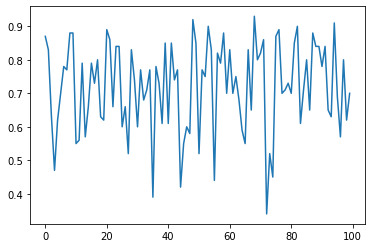

In [ ]:
acc_per_class_clean = PpC_measure(test_loader,model,num_classes=100)

classes = list(acc_per_class_clean.keys())
values = list(acc_per_class_clean.values())

plt.plot(classes,values)

#PpC under attacks

In [ ]:
!pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.9/155.9 KB 6.7 MB/s eta 0:00:00


In [ ]:
from torchattacks.attacks.pgd import PGD

In [ ]:
def PpC_attack(dataloader,model,num_classes):
  '''
  Return accuracy per class with poisoned data
  '''
  images_per_class = {i: 0 for i in range(num_classes)}
  correct_per_class = {i: 0 for i in range(num_classes)}

  attack = PGD(model, eps=3/255, alpha=1/255, steps=5, random_start=True)

  for x,y in tqdm(dataloader):
    x,y = x.to(device), y.to(device)
    preds_clean = model(x).argmax(1)
    adv_images = attack(x,y)
    preds_adv = model(adv_images).argmax(1)
    for i in range(num_classes):
      images_per_class[i] += (y == i).sum().item()
      correct_per_class[i] += ((preds_clean[y==i] == i) * (preds_adv[y==i] == i)).sum().item()
  
  for i in range(num_classes):
    correct_per_class[i] /= images_per_class[i]
  
  return correct_per_class

In [ ]:
acc_per_class_attack = PpC_attack(test_loader,model,num_classes=100)

classes_a = list(acc_per_class_attack.keys())
values_a = list(acc_per_class_attack.values())

100%|██████████| 313/313 [00:42<00:00,  7.41it/s]


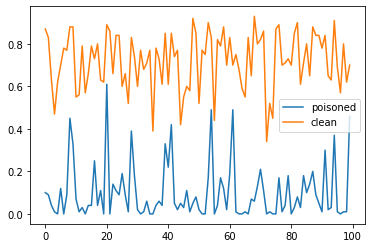

In [ ]:
plt.plot(classes_a,values_a,label='poisoned')
plt.plot(classes,values,label='clean')
plt.legend()

In [ ]:
coarse_id_fine_id = \
{0: [4, 30, 55, 72, 95],
1: [1, 32, 67, 73, 91],
2: [54, 62, 70, 82, 92],
3: [9, 10, 16, 28, 61],
4: [0, 51, 53, 57, 83],
5: [22, 39, 40, 86, 87],
6: [5, 20, 25, 84, 94],
7: [6, 7, 14, 18, 24],
8: [3, 42, 43, 88, 97],
9: [12, 17, 37, 68, 76],
10: [23, 33, 49, 60, 71],
11: [15, 19, 21, 31, 38],
12: [34, 63, 64, 66, 75],
13: [26, 45, 77, 79, 99],
14: [2, 11, 35, 46, 98],
15: [27, 29, 44, 78, 93],
16: [36, 50, 65, 74, 80],
17: [47, 52, 56, 59, 96],
18: [8, 13, 48, 58, 90],
19: [41, 69, 81, 85, 89]}

fine_id_coarse_id = dict()
for super_class,labels in coarse_id_fine_id.items():
  for label in labels:
    fine_id_coarse_id[label] = super_class

**Match of easy classes**

In [ ]:
sort_acc = sorted(acc_per_class_clean.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([fine_id_coarse_id[i[0]] for i in sort_acc[-15:]]))
print(labels)
sort_acc = sorted(acc_per_class_attack.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([fine_id_coarse_id[i[0]] for i in sort_acc[-15:]]))
print(labels)

[ 2  3  4  5  6  9 10 11 12 18]
[ 1  2  3  5  6 13 18 19]


**Match of hard classes**

In [ ]:
sort_acc = sorted(acc_per_class_clean.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([fine_id_coarse_id[i[0]] for i in sort_acc[:20]]))
print(labels)
sort_acc = sorted(acc_per_class_attack.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([fine_id_coarse_id[i[0]] for i in sort_acc[:20]]))
print(labels)

[ 0  1  3  6  8 12 13 14 15 16 17 18]
[ 0  4  7  8 11 12 14 16 17 18]


In [ ]:
attack = PGD(model, eps=8/255, alpha=2/255, steps=10, random_start=True)
images,labels = next(iter(test_loader))
images,labels = images.to(device),labels.to(device)
adv_images = attack(images, labels)

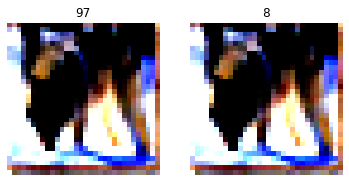

tensor(97, device='cuda:0')


In [ ]:
fig,axes = plt.subplots(1,2)
index = 17
pr_clean = model(images[index].unsqueeze(0)).argmax(1).item()
pr_attack = model(adv_images[index].unsqueeze(0)).argmax(1).item()
axes[0].imshow(images[index].cpu().permute(1,2,0).clip(0,1))
axes[0].set_title(f'{pr_clean}')
axes[1].set_title(f'{pr_attack}')
axes[1].imshow(adv_images[index].cpu().permute(1,2,0).clip(0,1))
axes[0].axis('off')
axes[1].axis('off')
plt.show()
print(labels[index])

#Adversarial Training

In [ ]:
weight_decay = 5e-4
epsilon = 8
batch_size = 32
alpha = 2
loss_weight = 0.3
fgsm_step = 1
delta_init = 'random'
train_loader, test_loader = get_loaders()
model = PreActResNet18(num_classes=100).to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler()
criterion = nn.CrossEntropyLoss()

data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)

mu = torch.tensor(data_mean).view(3, 1, 1).to(device)
std = torch.tensor(data_std).view(3, 1, 1).to(device)
upper_limit = ((1 - mu) / std)
lower_limit = ((0 - mu) / std)
epsilon = (epsilon / 255.) / std
alpha = (alpha / 255.) / std

if delta_init == 'previous':
    delta = torch.zeros(batch_size, 3, 32, 32).to(device)

prev_robust_acc = 0.

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.5e-4,weight_decay=weight_decay)

epochs = 25
loop = tqdm(range(epochs))
for epoch in loop:
    train_loss,train_acc,train_n = 0,0,0

    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        if delta_init != 'previous':
            delta = torch.zeros_like(X).to(device)
        if delta_init == 'random':
            for j in range(len(epsilon)):
                delta[:, j, :, :].uniform_(-epsilon[j][0][0].item(), epsilon[j][0][0].item())
            delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        if fgsm_step == 1:
            delta.requires_grad = True
            for _ in range(1):
                output = model(X + delta[:X.size(0)])
                loss = F.cross_entropy(output, y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                grad = delta.grad.detach()
                delta.data = clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
                delta.data[:X.size(0)] = clamp(delta[:X.size(0)], lower_limit - X, upper_limit - X)
                optimizer.zero_grad()
            delta = delta.detach()
            output = model(X + delta[:X.size(0)])
            loss = (1 - loss_weight) * criterion(output, y) + loss_weight * criterion(model(X), y)
            loss.backward()
            optimizer.step()
            
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        train_n += y.size(0)
      
    loop.set_description(f'train acc: {round(train_acc / train_n,3)}')

train acc: 0.547:  24%|██▍       | 6/25 [17:18<54:49, 173.14s/it]


KeyboardInterrupt: ignored

In [ ]:
best_state_dict_at = model.state_dict()

torch.save(best_state_dict,'model_at.pth')

In [ ]:
NUM_CLASSES = 100

def attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, lower_limit, upper_limit, args=None):

    max_loss = torch.zeros(y.shape[0]).to(device)
    max_delta = torch.zeros_like(X).to(device)
    scaler = torch.cuda.amp.GradScaler()

    for _ in range(restarts):
        delta = torch.zeros_like(X).to(device)
        for i in range(len(epsilon)):
            delta[:, i, :, :].uniform_(-epsilon[i][0][0].item(), epsilon[i][0][0].item())
        delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        delta.requires_grad = True

        for _ in range(attack_iters):
            with torch.cuda.amp.autocast():
                output = model(X + delta)
                index = torch.where(output.max(1)[1] == y)[0]
                if len(index) == 0:
                    break
                loss = F.cross_entropy(output, y)

            scaler.scale(loss).backward()
            grad = delta.grad.detach()

            d = delta[index, :, :, :]
            g = grad[index, :, :, :]
            d = clamp(d + alpha * torch.sign(g), -epsilon, epsilon)
            d = clamp(d, lower_limit - X[index, :, :, :], upper_limit - X[index, :, :, :])

            delta.data[index, :, :, :] = d
            delta.grad.zero_()

        all_loss = F.cross_entropy(model(X + delta), y, reduction='none').detach()
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    return max_delta


def evaluate_pgd(test_loader, model, attack_iters, restarts, epsilon, alpha, lower_limit, upper_limit, args=None):

    examples_per_class = {i : 0 for i in range(NUM_CLASSES)}
    correct_per_class = {i : 0 for i in range(NUM_CLASSES)}

    pgd_loss, pgd_acc = 0, 0
    n = 0
    model.eval()
    for i, (X, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
        X, y = X.to(device), y.to(device)
        pgd_delta = attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, lower_limit, upper_limit, args=args)
        with torch.no_grad():
            output = model(X + pgd_delta)
            preds = output.max(1)[1]
            for i in range(NUM_CLASSES):
                examples_per_class[i] += len(y[y==i])
                correct_per_class[i] += (preds[y==i] == i).sum().item()
            loss = F.cross_entropy(output, y)
            pgd_loss += loss.item() * y.size(0)
            pgd_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
        acc_per_class = {}
    for i in range(NUM_CLASSES):
        acc_per_class[i] = correct_per_class[i] / examples_per_class[i]
    return pgd_loss/n, pgd_acc/n,acc_per_class


def evaluate_standard(test_loader, model, args=None):
    
    examples_per_class = {i : 0 for i in range(NUM_CLASSES)}
    correct_per_class = {i : 0 for i in range(NUM_CLASSES)}
    
    test_loss, test_acc = 0, 0
    n = 0
    model.eval()
    with torch.no_grad():
        for i, (X, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
            X, y = X.to(device), y.to(device)
            output = model(X)
            preds = output.max(1)[1]
            for i in range(NUM_CLASSES):
                examples_per_class[i] += len(y[y==i])
                correct_per_class[i] += (preds[y==i] == i).sum().item()
            loss = F.cross_entropy(output, y)
            test_loss += loss.item() * y.size(0)
            test_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
    acc_per_class = {}
    for i in range(NUM_CLASSES):
        acc_per_class[i] = correct_per_class[i] / examples_per_class[i]
    return test_loss/n, test_acc/n,acc_per_class


In [ ]:
# Evaluation
model_at = PreActResNet18(num_classes=100).to(device)
model_at.load_state_dict(best_state_dict_at)
model_at.float()
model_at.eval()


pgd_loss, pgd_acc, acc_cl_pgd_at = evaluate_pgd(test_loader, model_at, 1, 5, epsilon, alpha, 
                                  lower_limit, upper_limit)
test_loss, test_acc, acc_cl_standart_at = evaluate_standard(test_loader, model_at)
print(test_acc,pgd_acc)

100%|██████████| 313/313 [00:09<00:00, 33.83it/s]

0.6828 0.4098


#PpC after adv training

In [ ]:
classes_at = list(acc_cl_pgd_at.keys())
values_at = list(acc_cl_pgd_at.values())
print(acc_cl_pgd_at)

{0: 0.67, 1: 0.64, 2: 0.26, 3: 0.12, 4: 0.1, 5: 0.37, 6: 0.43, 7: 0.4, 8: 0.41, 9: 0.54, 10: 0.22, 11: 0.23, 12: 0.52, 13: 0.29, 14: 0.3, 15: 0.33, 16: 0.54, 17: 0.54, 18: 0.38, 19: 0.32, 20: 0.73, 21: 0.69, 22: 0.44, 23: 0.61, 24: 0.73, 25: 0.37, 26: 0.34, 27: 0.22, 28: 0.54, 29: 0.41, 30: 0.24, 31: 0.29, 32: 0.44, 33: 0.22, 34: 0.33, 35: 0.1, 36: 0.48, 37: 0.36, 38: 0.14, 39: 0.67, 40: 0.46, 41: 0.64, 42: 0.25, 43: 0.39, 44: 0.11, 45: 0.29, 46: 0.24, 47: 0.3, 48: 0.78, 49: 0.48, 50: 0.15, 51: 0.38, 52: 0.55, 53: 0.82, 54: 0.57, 55: 0.04, 56: 0.59, 57: 0.49, 58: 0.7, 59: 0.33, 60: 0.68, 61: 0.31, 62: 0.4, 63: 0.32, 64: 0.25, 65: 0.11, 66: 0.51, 67: 0.31, 68: 0.73, 69: 0.58, 70: 0.39, 71: 0.56, 72: 0.07, 73: 0.27, 74: 0.15, 75: 0.64, 76: 0.66, 77: 0.25, 78: 0.31, 79: 0.21, 80: 0.09, 81: 0.29, 82: 0.75, 83: 0.42, 84: 0.34, 85: 0.5, 86: 0.48, 87: 0.57, 88: 0.43, 89: 0.59, 90: 0.51, 91: 0.58, 92: 0.24, 93: 0.19, 94: 0.75, 95: 0.55, 96: 0.19, 97: 0.43, 98: 0.22, 99: 0.63}


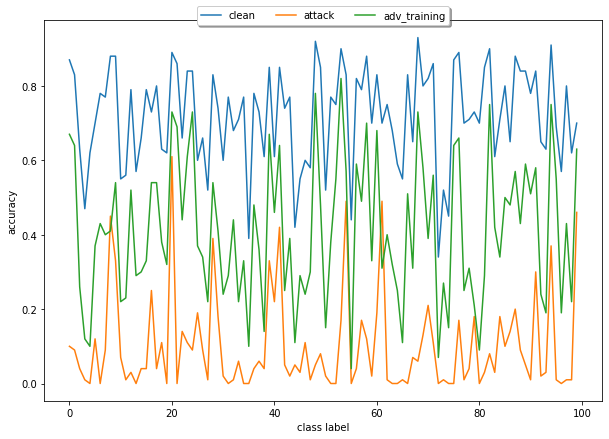

In [ ]:
x = [classes,classes_a,classes_at] 
y = [values,values_a,values_at]
labels = ['clean','attack','adv_training']
fig = plt.figure(figsize = (10,7))
ax = plt.subplot(111)

for i in range(3):
    line, = ax.plot(x[i], y[i], label=labels[i])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

plt.xlabel('class label')
plt.ylabel('accuracy')
plt.show()


#Check match of easy classses

On coarse labels

In [ ]:
sort_acc = sorted(acc_per_class_clean.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([fine_id_coarse_id[i[0]] for i in sort_acc[-15:]]))
print('on clear images',labels,end = '\n\n')
sort_acc = sorted(acc_per_class_attack.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([fine_id_coarse_id[i[0]] for i in sort_acc[-15:]]))
print('on poisoned images',labels)
sort_acc = sorted(acc_cl_pgd_at.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([fine_id_coarse_id[i[0]] for i in sort_acc[-15:]]))
print('after adv training',labels)

on clear images [ 2  3  4  5  6  9 10 11 12 18]

on poisoned images [ 1  2  3  5  6 13 18 19]
after adv training [ 2  4  5  6  7  9 10 11 12 18 19]


On fine labels

In [ ]:
sort_acc = sorted(acc_per_class_clean.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = sorted(np.array([i[0] for i in sort_acc[-15:]]))
print(' on clear images   ','  '.join(map(str,labels)),end='\n\n')
sort_acc = sorted(acc_per_class_attack.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = sorted(np.array([i[0] for i in sort_acc[-15:]]))
print('on poisoned images','  '.join(map(str,labels)))
sort_acc = sorted(acc_cl_pgd_at.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = sorted(np.array([i[0] for i in sort_acc[-15:]]))
print('after adv training','  '.join(map(str,labels)))

 on clear images    0  8  9  20  21  48  53  58  68  71  75  76  82  87  94

on poisoned images 8  9  16  20  28  39  40  41  54  61  70  87  91  94  99
after adv training 0  20  21  24  39  41  48  53  58  60  68  75  76  82  94


#Check match of hard classes

On coarse labels

In [ ]:
sort_acc = sorted(acc_per_class_clean.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([fine_id_coarse_id[i[0]] for i in sort_acc[0:15]]))
print('on clear images',labels,end = '\n\n')
sort_acc = sorted(acc_per_class_attack.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([fine_id_coarse_id[i[0]] for i in sort_acc[0:15]]))
print('on poisoned images',labels)
sort_acc = sorted(acc_cl_pgd_at.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = np.unique(np.array([fine_id_coarse_id[i[0]] for i in sort_acc[0:15]]))
print('after adv training',labels)

on clear images [ 0  1  3  8 13 14 15 16 17 18]

on poisoned images [ 0  4  7 11 12 14 17 18]
after adv training [ 0  3  8 11 13 14 15 16 17]


On fine labels

In [ ]:
sort_acc = sorted(acc_per_class_clean.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = sorted(np.array([i[0] for i in sort_acc[0:15]]))
print(' on clear images   ','  '.join(map(str,labels)),end='\n\n')
sort_acc = sorted(acc_per_class_attack.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = sorted(np.array([i[0] for i in sort_acc[:15]]))
print('on poisoned images','  '.join(map(str,labels)))
sort_acc = sorted(acc_cl_pgd_at.items(), key=lambda x:x[1])
# print(sorted([i[0] for i in sort_acc[-15:]]))
labels = sorted(np.array([i[0] for i in sort_acc[:15]]))
print('after adv training','  '.join(map(str,labels)))

 on clear images    3  10  11  13  27  35  44  45  50  55  65  72  73  74  96

on poisoned images 4  6  13  19  21  31  34  35  51  52  55  63  64  66  72
after adv training 3  4  10  35  38  44  50  55  65  72  74  79  80  93  96
